<a href="https://colab.research.google.com/github/pachterlab/BI-BE-CS-183-2023/blob/main/HW6/Problem3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Bi/Be/Cs 183 2022-2023: Intro to Computational Biology
TAs: Meichen Fang, Tara Chari, Zitong (Jerry) Wang

**Submit your notebooks by sharing a clickable link with Viewer access. Link must be accessible from submitted assignment document.**

Make sure Runtime $\rightarrow$ Restart and run all works without error

**HW 6 Problem 3**

In this problem you will test different methods for variance stabilization on real single-cell datasets, and analyze the results of these procedures. This follows a recent [paper](https://www.biorxiv.org/content/biorxiv/early/2021/08/25/2021.06.24.449781.full.pdf) and [blog post](https://www.nxn.se/valent/2017/10/15/variance-stabilizing-scrna-seq-counts) about their effects in single-cell.


##**Import data and install packages**

In [6]:
import numpy as np
import scipy.io as sio
import pandas as pd
import matplotlib.pyplot as plt #Can use other plotting packages like seaborn

In [7]:
#Download the gene count matrix for Drop-seq Drospohila embryo data
!wget --content-disposition https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2494nnn/GSM2494783/suppl/GSM2494783_dge_mel_vir_rep1.txt.gz

--2023-02-21 00:09:09--  https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2494nnn/GSM2494783/suppl/GSM2494783_dge_mel_vir_rep1.txt.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.7, 130.14.250.11
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6388719 (6.1M) [application/x-gzip]
Saving to: 'GSM2494783_dge_mel_vir_rep1.txt.gz.1'

GSM2494783_dge_mel_ 100%[===================>]   6.09M  1021KB/s    in 5.1s    

2023-02-21 00:09:15 (1.20 MB/s) - 'GSM2494783_dge_mel_vir_rep1.txt.gz.1' saved [6388719/6388719]



In [8]:
!gunzip GSM2494783_dge_mel_vir_rep1.txt.gz

GSM2494783_dge_mel_vir_rep1.txt already exists -- do you wish to overwrite (y or n)? ^C


## **Read in data for analysis**

**The dataset**

This dataset is from a Drop-seq experiment whose purpose was to conduct a single-cell study of the early *Drosophila* (fruit fly) embryo at particular stages of development ([Karaiskos et al., 2017](http://dx.doi.org/10.1126/science.aan3235)), from both *Drosophila melanogaster* and *Drosophila virilis* species. Over 5000 embryos were sequenced to  generate a predictive 3D map of gene expression during development across the embryo (using previous *in situ* hybridization data).

<center><img src="https://drive.google.com/uc?export=view&id=1p4qrvbhjGahIQL1s3M-UzAFbqhuNyTt7" alt="EMFigure" width="600" height="300"><center>



**The count matrix**

The gene count matrix is 3,247 cells by 23,712 genes. These counts have not been processed/normalized, so they directly represent the UMI counts from each cell.


In [9]:
#Get gene count matrix
data = pd.read_csv('GSM2494783_dge_mel_vir_rep1.txt', sep='\t',index_col=0)
data.head()

,CATCTTGGTTCN,GTACTAATTACN,GGAAACACGTTC,ACGCACAACTCN,AGAGCTCGTGTA,AATCACCTCCAA,CATAATTTAGCT,GTGTATTTGTCN,TTCTTCACTTTC,CCAGTGTCTTGC,...,TTCCCTAGGTAA,CCTGTAGCGATA,TAAGGGCGCCTC,ATCTGACCAGAA,ATTCCCACTCGT,ATTCCTTATTAG,CGGTAAGCAGGC,AGCAATGAGTCT,CTTCACCTAAGA,TCGCTAATGCCN
GENE,,,,,,,,,,,,,,,,,,,,,
128up,6,4,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
14-3-3epsilon,665,370,4,5,1,1,4,1,0,8,...,4,2,0,0,1,0,0,1,3,1
14-3-3zeta,120,49,0,1,0,0,1,0,0,4,...,0,0,0,0,1,0,0,0,0,0
140up,6,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18SrRNA-Psi:CR41602,4,0,3,0,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [10]:
#Extract just the counts and transpose (to get cells x genes)
count_mat = data.to_numpy().T
count_mat.shape

(3247, 23712)

## **Problem 3 (40 points)**

For our purposes, we will use the $\mu,\phi$ parametrization of the negative binomial (NB) for this problem. Here $\phi$ is the dispersion and $\mu$ is the mean.

In this configuration, $\operatorname {var}(X) = \mu + \phi\mu^2$ (unlike the Poisson where $\operatorname{var}(X) = \mu$). $x_i$ represents expression of gene $i$.


As described in the assignment, we can find a variance-stabilizing transform, where given
\begin{align}
\operatorname {var} (X)=h(\mu ),\,
\end{align}
a suitable transform would be
\begin{align}
 y\propto \int ^{x}{\frac {1}{\sqrt {h(\mu )}}}\,d\mu 
\end{align}
to result in a constant (mean-independent) variance.


### **a) Find the expression for the transformation $y$ given the var $(X)$ expression for a NB (given in the Problem statement). (5 points)**

If working by hand attach an image of your work, or directly type your answer into a text cell. Feel free to use https://www.wolframalpha.com/ for the integral calculation.


To find the expression for the variance-stabilizing transformation, we need to solve the following equation for $h(\mu)$:

$$\operatorname{var}(X) = h(\mu)$$
For the negative binomial distribution, we have:
$$\operatorname{var}(X) = \mu + \phi\mu^2 = h(\mu)$$

We can then use the formula for the variance-stabilizing transformation:
$$y\propto \int ^{x}{\frac {1}{\sqrt {h(\mu)}}},d\mu$$
Substituting $h(\mu)$, we get:
$$y\propto \int ^{x}{\frac {1}{\sqrt{\mu + \phi\mu^2}}},d\mu$$


Solving for $y$, we get:
$$y = \frac{2 sinh^{-1}(\sqrt{\phi \mu})}{\sqrt{\phi}}$$

### **b) Run PCA on the data matrix (with genes as features), extract the top two principal components and transform the data matrix, then plot the cells in their 2D, transformed coordinates. (5 points)**

You can use the [sklearn PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function, similar to HW3.

In [49]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [50]:
data.columns = data.columns.astype(str)
data.index = data.index.astype(str)

In [51]:
transformed.shape

(3247, 2)

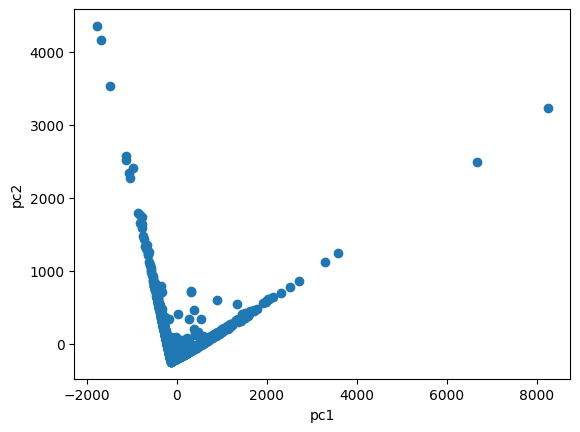

In [21]:
pca = PCA(n_components=2)
transformed = pca.fit_transform(count_mat)
plt.scatter(transformed[:, 0], transformed[:, 1])
plt.xlabel("pc1")
plt.ylabel("pc2")
plt.show()

### **c) Plot the variance ($\sigma^2$) versus the mean ($\mu$) expression for all genes in a single plot, and comment on any trends you notice (how variance relates to the mean). (5 points)**

You will need to calculate a $\mu$ and $\sigma^2$ for each gene.

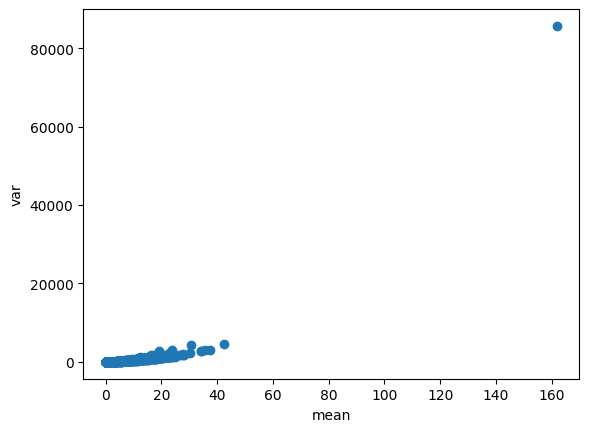

In [22]:
mean = np.mean(count_mat, axis=0)
var = np.var(count_mat, axis=0)

plt.scatter(mean, var)
plt.xlabel("mean")
plt.ylabel("var")
plt.show()

This plot shows that as the mean increases, so does the variance with a quadratic relationship. 

### **d) Fit a polynomial to $\sigma^2$ vs $\mu$ (the plot from c) to approximate a single $\phi$ value (across all genes). (5 points)**

$\sigma^2$ is var $(X)$ . Given that  $\operatorname {var}(X) = \mu + \phi\mu^2$ you can find the fit for $\phi$ as the coefficent for the squared term.
 
You can use the package [curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) to define this degree 2 polynomial where $x=\mu$, $y=$ var $(X)$ . Using the bounds options you can constrain the constant to be 0, the first coefficient to be 1, and learn the second coefficient ($\phi$). 

See constrained fit example [here](https://stackoverflow.com/questions/48469889/how-to-fit-a-polynomial-with-some-of-the-coefficients-constrained).

**Report your value of $\phi$ from the fit (one value across all genes).**

In [23]:
from scipy.optimize import curve_fit

In [34]:
def curve(x, a, b, c):
    return a + b*x + c*x**2

eps = 1e-10
fit = curve_fit(curve, mean, var, bounds=([0, 1, -np.inf], [0 + eps, 1 + eps, np.inf]))
phi = fit[0][2]
print(f"phi is {phi}")

phi is 3.252637490767278


### **e) Run the log1p, Pearson residual, and $\mathbf{\text{sinh}^{-1}}$ variance stabilization transforms on the full dataset. (10 points)**

Below you will test out the effect of common variance-stabilization procedures.

[In 1948](https://academic.oup.com/biomet/article-abstract/35/3-4/246/280278?redirectedFrom=fulltext), Frank Anscombe developed several transformations for the Poisson and NB distributions including

\begin{align}
y \propto \dfrac{\text{sinh}^{-1}(\sqrt{\phi x_i})}{\sqrt{\phi}} \tag{1}
\end{align} and
\begin{align}
y \propto \text{log}(x_i+\dfrac{1}{2\phi}) \tag{2}
\end{align} (similar to the log1p we've seen before) which can approximate the $\text{sinh}^{-1}$ solution.



Another common method is to use Pearson residuals, shown below:

\begin{align}
y \propto \dfrac{x_i − \mu_i}{\sqrt{\mu_i + \phi \mu_i^2}}. \tag{3}
\end{align}

Again $x_i$ represents expression of gene $i$.

**After running each transformation (on the full data), print *only* the transformed values for the first gene, for the first 10 cells, under each transform (1-3).**

In [42]:
log1p_transform = np.log(count_mat + 1/(2*phi))
pearson_transform = (count_mat - mean)/np.sqrt(mean + phi * mean**2)
sinh_transform = np.arcsinh(np.sqrt(phi * count_mat)) / np.sqrt(phi)

In [39]:
np.array(log1p_transform)[:10, 0]

array([ 1.81705701,  1.42400466, -1.87261338, -1.87261338, -1.87261338,
       -1.87261338, -1.87261338, -1.87261338, -1.87261338, -1.87261338])

In [40]:
np.array(pearson_transform)[:10, 0]

array([23.94594986, 15.89328566, -0.21204274, -0.21204274, -0.21204274,
       -0.21204274, -0.21204274, -0.21204274, -0.21204274, -0.21204274])

In [43]:
np.array(sinh_transform)[:10, 0]

array([1.21503868, 1.10601807, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

### **f) For each of the three transformation methods, make a single plot of the variance ($\sigma^2$) versus the mean ($\mu$) for all genes, and comment on the trends you notice (particularly compared to c). (5 points)**

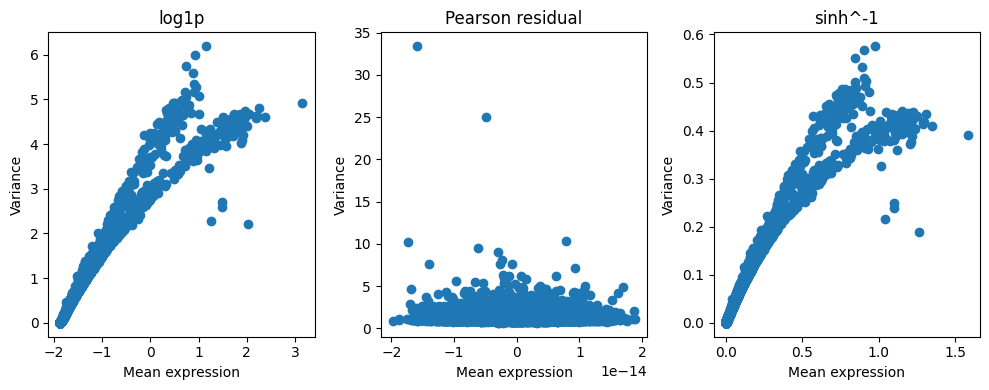

In [44]:
#Plot the variance versus the mean expression for each of the three variance-stabilizing transforms
plt.figure(figsize=(10, 4))

# Plot the log1p transformed data
plt.subplot(131)
plt.scatter(np.mean(log1p_transform, axis=0), np.var(log1p_transform, axis=0))
plt.xlabel('Mean expression')
plt.ylabel('Variance')
plt.title('log1p')

# Plot the Pearson residual transformed data
plt.subplot(132)
plt.scatter(np.mean(pearson_transform, axis=0), np.var(pearson_transform, axis=0))
plt.xlabel('Mean expression')
plt.ylabel('Variance')
plt.title('Pearson residual')

# Plot the sinh^-1 transformed data
plt.subplot(133)
plt.scatter(np.mean(sinh_transform, axis=0), np.var(sinh_transform, axis=0))
plt.xlabel('Mean expression')
plt.ylabel('Variance')
plt.title('sinh^-1')

plt.tight_layout()
plt.show()

log and sinh look pretty similar, both are more linear than previously, but have some curvature to the trend. Pearson is all over the place. All of the trends control for outliers more and are centered at 0 as well. 

### **g) For each transformation, run PCA on the variance-stabilized data matrices (with genes as features), extract the top two principal components and transform the matrix, then plot the cells in their 2D, transformed coordinates. There should be one plot for each transformation method. Comment on how these plots compare to that of b. (5 points)**

In [46]:
def plot_pca(data, title):
    pca = PCA(n_components=2)
    transformed = pca.fit_transform(data)
    plt.scatter(transformed[:, 0], transformed[:, 1])
    plt.xlabel("pc1")
    plt.ylabel("pc2")
    plt.title(title)
    plt.show()

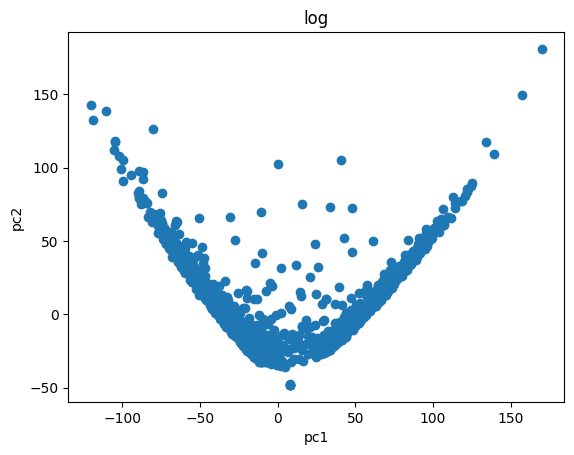

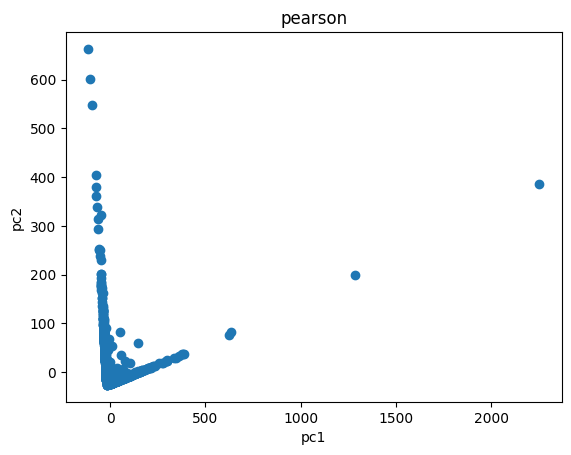

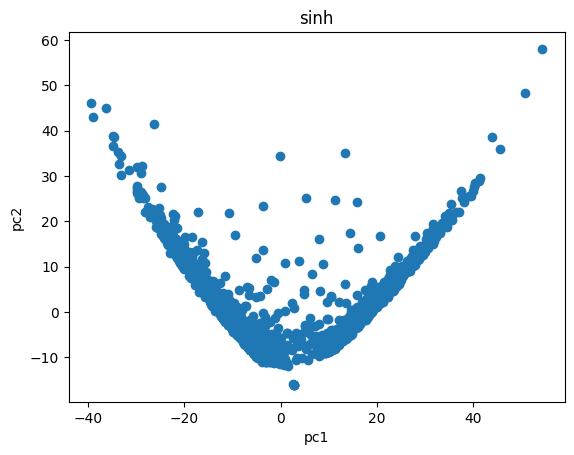

In [48]:
plot_pca(log1p_transform, "log")
plot_pca(pearson_transform, "pearson")
plot_pca(sinh_transform, "sinh")

The log transform and the sinh transform both look similar to each other, while the pearson transform is more similar to the original plot we had of the PCs. For log and sinh, the plots are more symmetrical and allow for a better separation of the groups. 